In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# data separation/transformation
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE # Recursive Feature Elimination¶

# modeling
from sklearn.cluster import KMeans
import sklearn.preprocessing

# statistics testing
import scipy.stats as stats

# system manipulation
from itertools import combinations
import os
import sys
sys.path.append("../util_")
import prepare_
import explore_

# other
import math
import env
import warnings
warnings.filterwarnings("ignore")

# set the random seed
np.random.seed(95)

**Get data**

In [2]:
# This data is already been split and save
# This is only training data
train_scaled = pd.read_csv("./00_project_data/1-1_training_data.csv", index_col=0)
train_scaled = train_scaled.reset_index(drop=True)
train_scaled.head()

,fixed_acidity_scaled,volatile_acidity_scaled,citric_acid_scaled,residual_sugar_scaled,chlorides_scaled,free_sulfur_dioxide_scaled,total_sulfur_dioxide_scaled,density_scaled,ph_scaled,sulphates_scaled,alcohol_scaled,quality,wine_clr,red,white,clusters_3,clusters_2
0,0.173554,0.144,0.195122,0.058065,0.074725,0.173010,0.349515,0.225528,0.705426,0.289773,0.478261,5,white,0,1,0,1
1,0.297521,0.248,0.186992,0.206452,0.046154,0.186851,0.332871,0.297111,0.325581,0.113636,0.362319,5,white,0,1,0,0
2,0.338843,0.488,0.170732,0.048387,0.149451,0.214533,0.374480,0.391979,0.410853,0.164773,0.275362,5,red,1,0,2,0
3,0.165289,0.168,0.040650,0.006452,0.057143,0.062284,0.066574,0.228116,0.496124,0.073864,0.173913,5,white,0,1,0,0
4,0.181818,0.080,0.219512,0.029032,0.169231,0.262976,0.380028,0.223803,0.596899,0.227273,0.405797,6,white,0,1,0,1


## Feature Selection

**Set feature for selection**

In [3]:
# Separate quality column and wine_clr column from the x_features
feature_cols = train_scaled.columns[~train_scaled.columns.isin(["quality", "wine_clr"])]
feature_cols

Index(['fixed_acidity_scaled', 'volatile_acidity_scaled', 'citric_acid_scaled',
       'residual_sugar_scaled', 'chlorides_scaled',
       'free_sulfur_dioxide_scaled', 'total_sulfur_dioxide_scaled',
       'density_scaled', 'ph_scaled', 'sulphates_scaled', 'alcohol_scaled',
       'red', 'white', 'clusters_3', 'clusters_2'],
      dtype='object')

In [4]:
# separate features from target
x_features = train_scaled[feature_cols]
y_target = train_scaled["quality"]
x_features.head()

,fixed_acidity_scaled,volatile_acidity_scaled,citric_acid_scaled,residual_sugar_scaled,chlorides_scaled,free_sulfur_dioxide_scaled,total_sulfur_dioxide_scaled,density_scaled,ph_scaled,sulphates_scaled,alcohol_scaled,red,white,clusters_3,clusters_2
0,0.173554,0.144,0.195122,0.058065,0.074725,0.173010,0.349515,0.225528,0.705426,0.289773,0.478261,0,1,0,1
1,0.297521,0.248,0.186992,0.206452,0.046154,0.186851,0.332871,0.297111,0.325581,0.113636,0.362319,0,1,0,0
2,0.338843,0.488,0.170732,0.048387,0.149451,0.214533,0.374480,0.391979,0.410853,0.164773,0.275362,1,0,2,0
3,0.165289,0.168,0.040650,0.006452,0.057143,0.062284,0.066574,0.228116,0.496124,0.073864,0.173913,0,1,0,0
4,0.181818,0.080,0.219512,0.029032,0.169231,0.262976,0.380028,0.223803,0.596899,0.227273,0.405797,0,1,0,1


**RFS**

Use recursive feature elimination to select the top 5 features for predicting wine quality.

In [5]:
# make a model object to use in RFE process.
linear_model = LinearRegression()

# MAKE the RFE object
rfe = RFE(linear_model, n_features_to_select=1)

# FIT the RFE object to the training data
rfe.fit(x_features, y_target)

# odered from most important to least important
rfe.ranking_

array([ 8,  2, 14,  6, 11,  4,  5,  7,  9,  3,  1, 12, 10, 15, 13])

In [6]:
# get a dataframe of the top 5 columns orderd by importance
x_feature_selected = x_features.iloc[:, rfe.ranking_[0:5] - 1] # -1 beacuse rfe rank starts at 1
x_feature_selected.head(3)

# More important to least important

,density_scaled,volatile_acidity_scaled,clusters_3,free_sulfur_dioxide_scaled,alcohol_scaled
0,0.225528,0.144,0,0.173010,0.478261
1,0.297111,0.248,0,0.186851,0.362319
2,0.391979,0.488,2,0.214533,0.275362


## Cluster Model

**Get validation and test data**

In [7]:
# Validation data
val_scaled = pd.read_csv("./00_project_data/1-2_validation_data.csv", index_col=0)
val_scaled = val_scaled.reset_index(drop=True)

# Test data
test_scaled = pd.read_csv("./00_project_data/1-3_testing_data.csv", index_col=0)
test_scaled = test_scaled.reset_index(drop=True)

**Make combinations**

In [8]:
# Get all continous columns for cobinations and leave the encoded columns
columns_to_combine = x_feature_selected.columns[~x_feature_selected.columns.isin(["white", "clusters_3", "clusters_2"])]

feature_combinations = list(combinations(columns_to_combine, 2))
feature_combinations

[('density_scaled', 'volatile_acidity_scaled'),
 ('density_scaled', 'free_sulfur_dioxide_scaled'),
 ('density_scaled', 'alcohol_scaled'),
 ('volatile_acidity_scaled', 'free_sulfur_dioxide_scaled'),
 ('volatile_acidity_scaled', 'alcohol_scaled'),
 ('free_sulfur_dioxide_scaled', 'alcohol_scaled')]

**Visualize**

DENSITY_SCALED VS VOLATILE_ACIDITY_SCALED


<Figure size 1600x800 with 0 Axes>

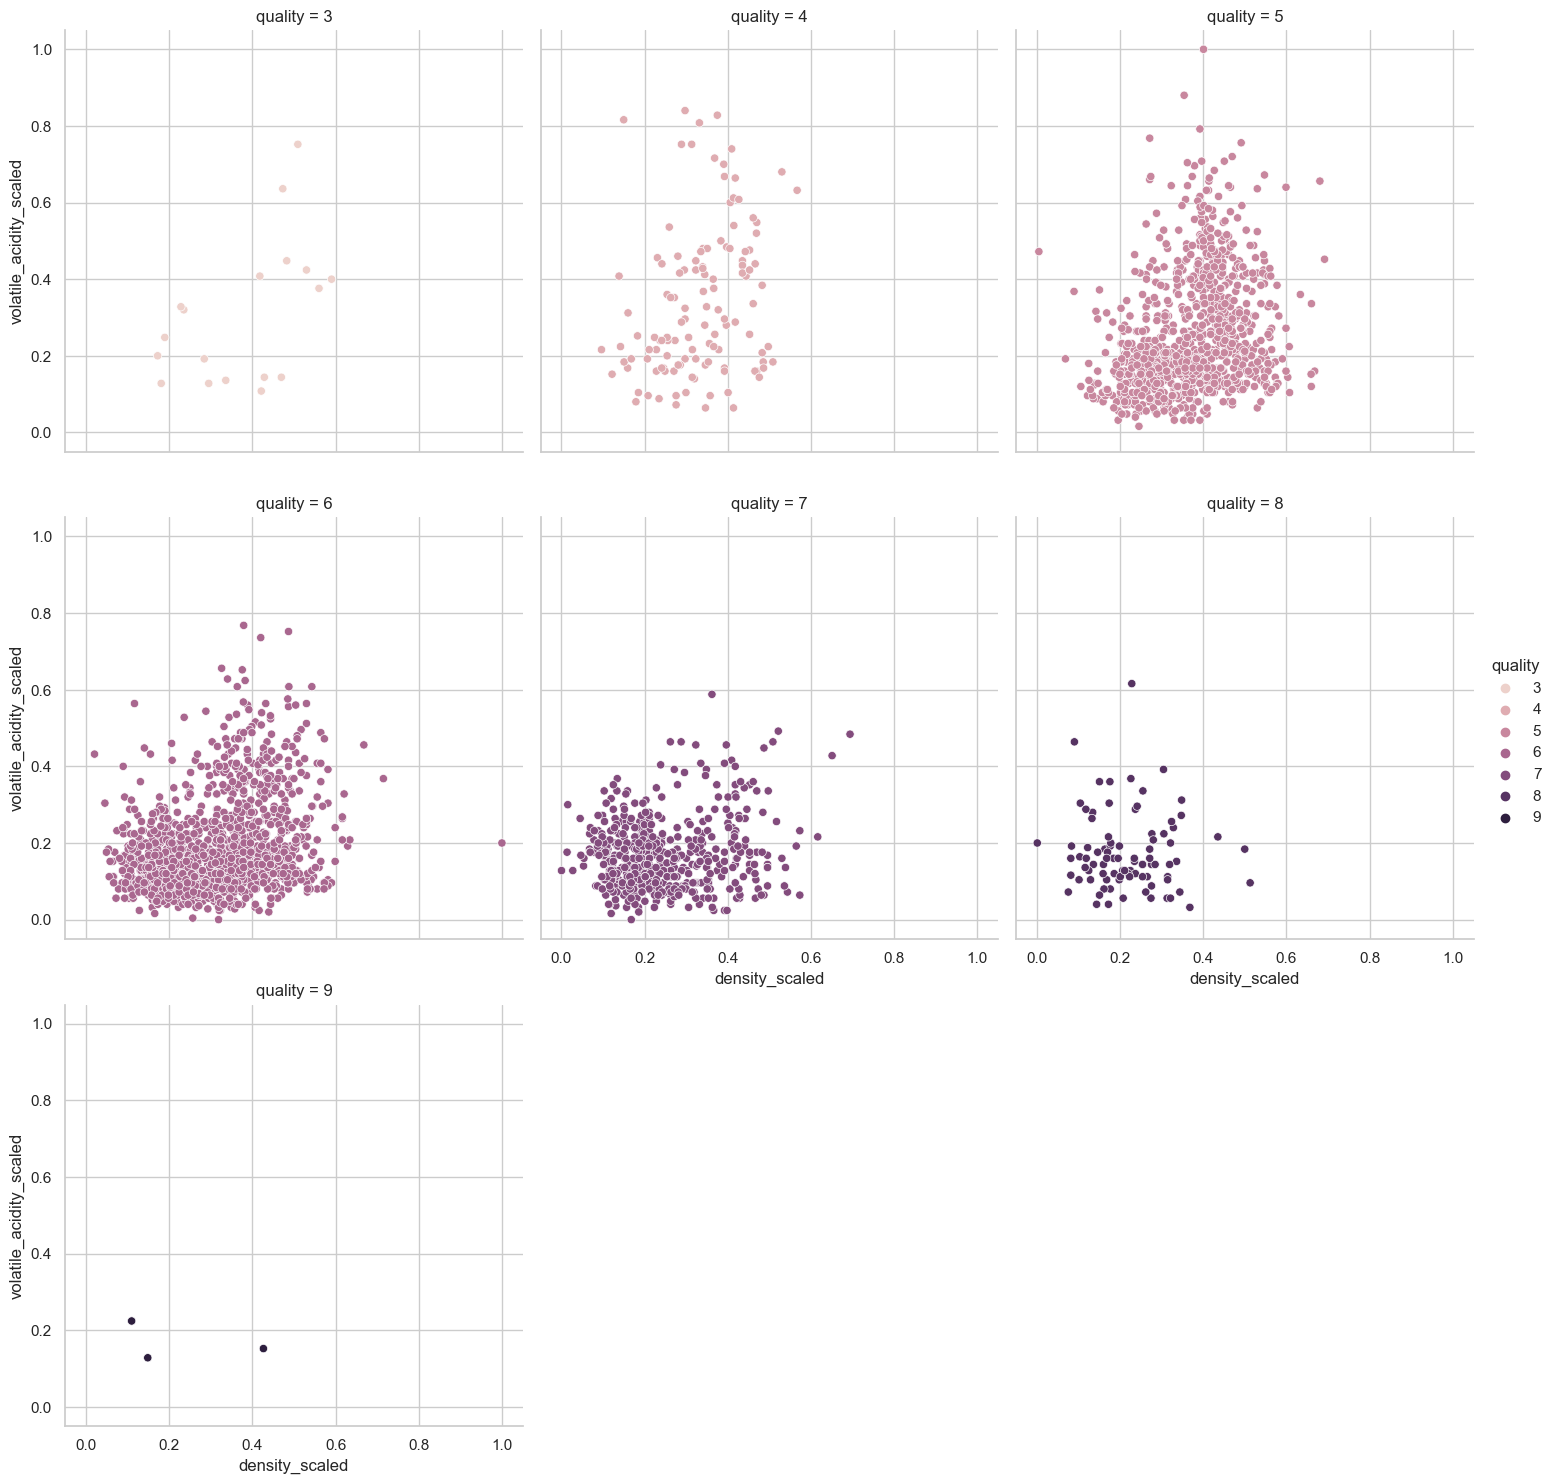

DENSITY_SCALED VS FREE_SULFUR_DIOXIDE_SCALED


<Figure size 1600x800 with 0 Axes>

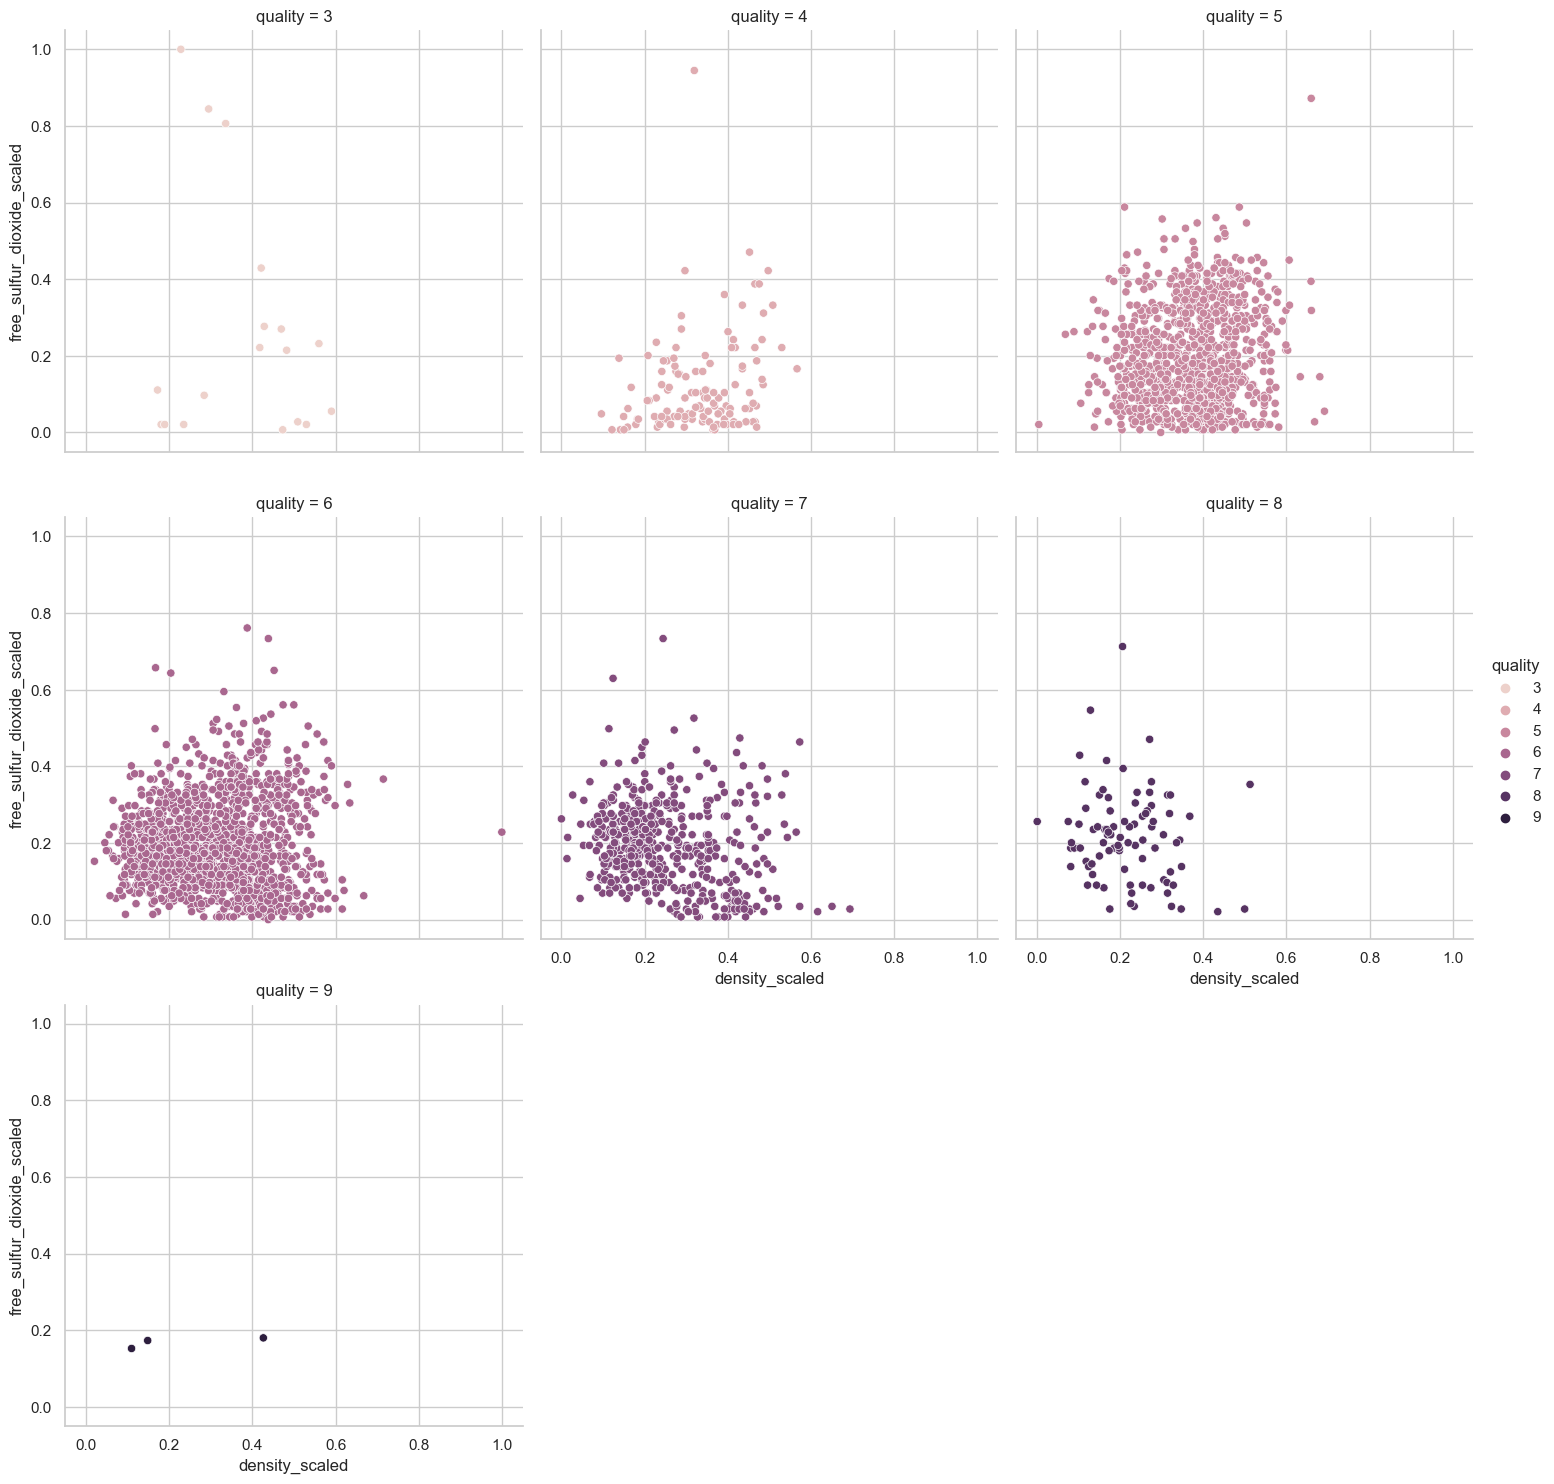

DENSITY_SCALED VS ALCOHOL_SCALED


<Figure size 1600x800 with 0 Axes>

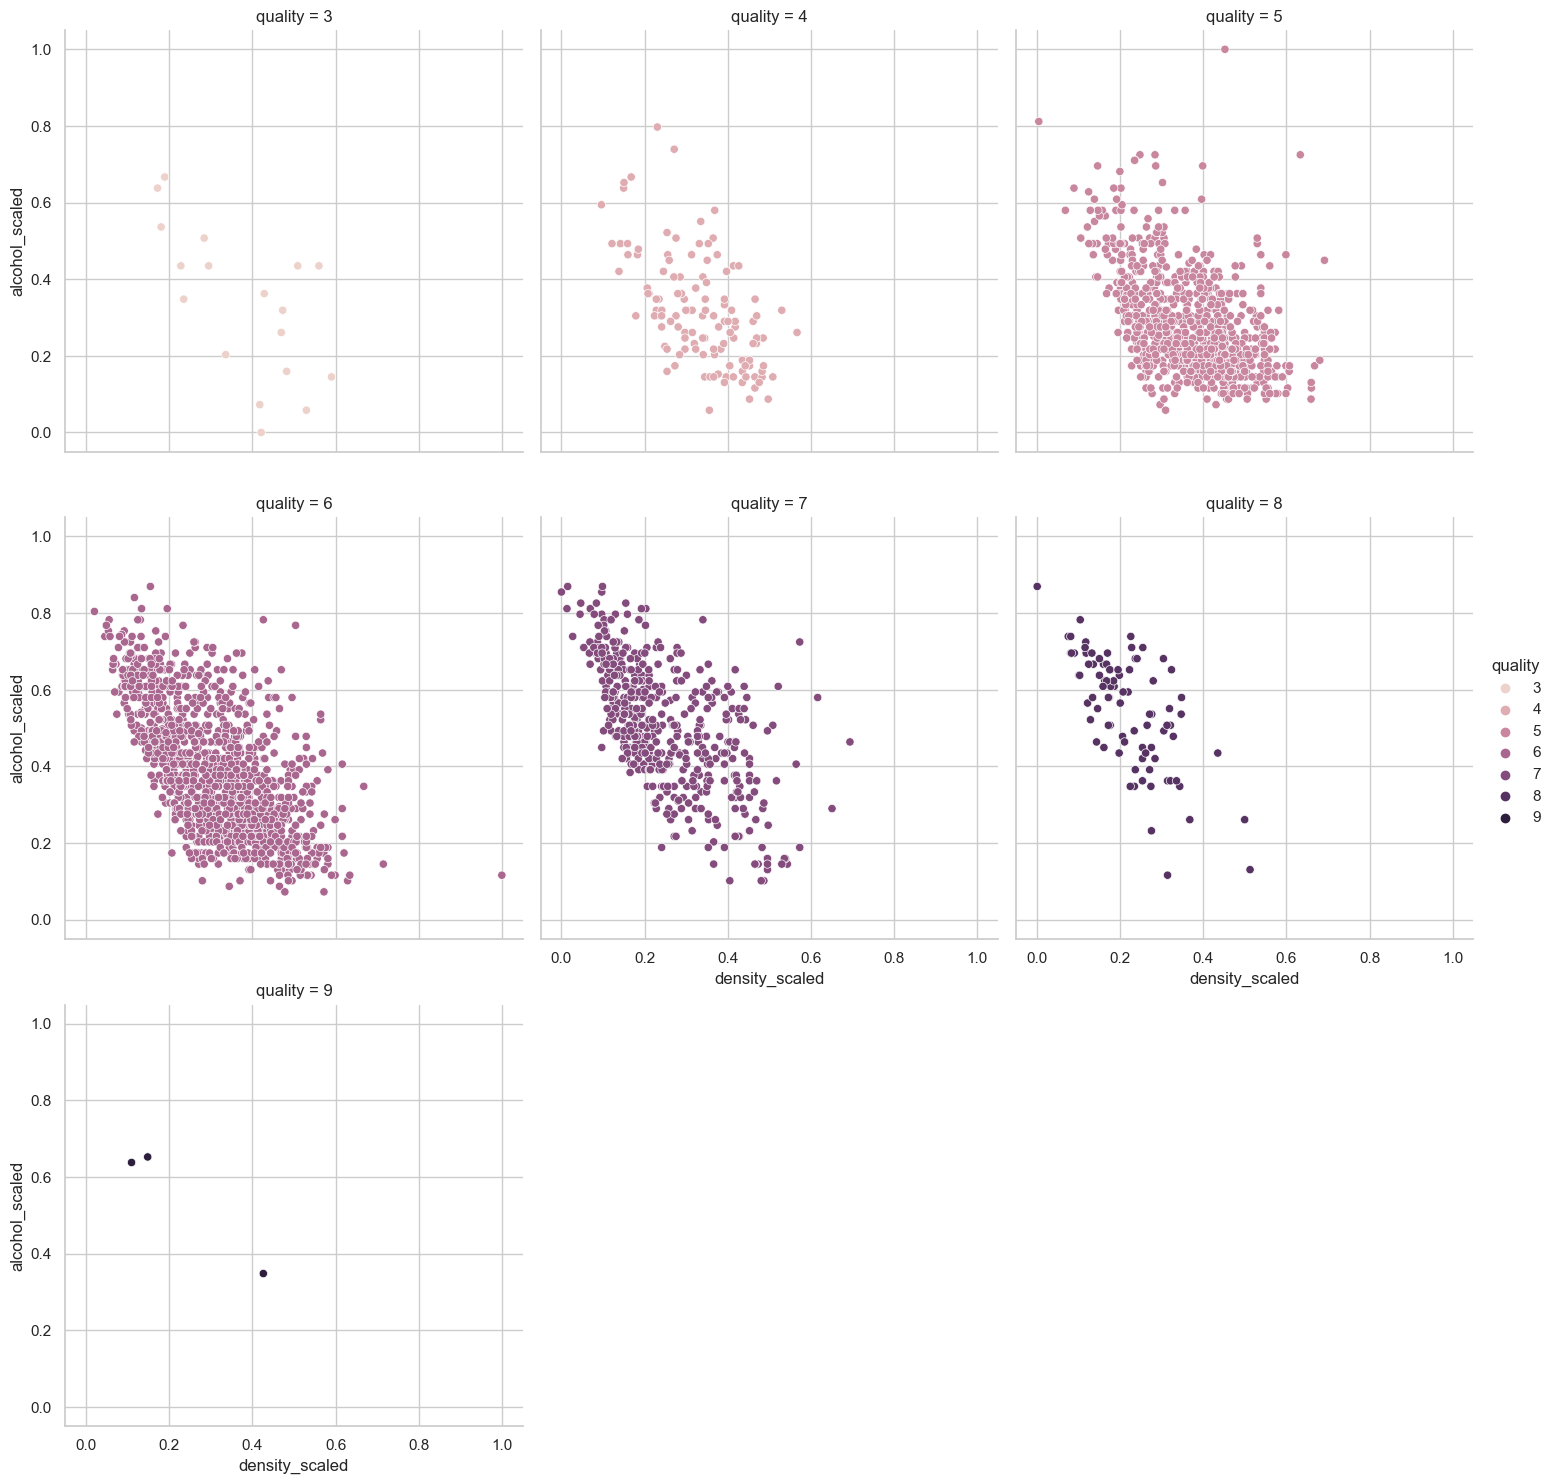

In [9]:
for comb in feature_combinations[:3]:
    print(comb[0].upper(), "VS", comb[1].upper())
    plt.figure(figsize=(16,8))
    sns.relplot(data=train_scaled, x=comb[0], y=comb[1], 
                hue="quality", col="quality", col_wrap=3)
    plt.show()

In [10]:
feature_combinations[2]

('density_scaled', 'alcohol_scaled')

**Create, fit and predict**

In [11]:
# Create dataframe to save mode predictions
model_df = pd.DataFrame({"index_col":np.arange(len(train_scaled))})
model_df2 = pd.DataFrame({"index_col":np.arange(len(train_scaled))})

In [12]:
# set the max number ok of k to loop through
# 5% of the data
iter = math.ceil(len(train_scaled) * 0.005)

model_centers = []
model_inertia = []
model_centers2 = []
model_inertia2 = []

for k in range(1,iter + 1):
    # ceate model object
    kmean = KMeans(n_clusters= k)
    kmean2 = KMeans(n_clusters= k)

    # fit model object
    kmean.fit(train_scaled[list(feature_combinations[0])])
    kmean2.fit(train_scaled[list(feature_combinations[2])])

    # make predictions
    label = kmean.predict(train_scaled[list(feature_combinations[0])])
    label2 = kmean2.predict(train_scaled[list(feature_combinations[2])])
    
    # add predictions to the original dataframe
    model_df[f"clusters_{k}"] = label
    model_df2[f"clusters_{k}"] = label2

    # view ceters
    model_centers.append(kmean.cluster_centers_)
    model_centers2.append(kmean2.cluster_centers_)
    
    model_inertia.append(kmean.inertia_)
    model_inertia2.append(kmean2.inertia_)

In [13]:
# look at the different models we got
model_df.head()

,index_col,clusters_1,clusters_2,clusters_3,clusters_4,clusters_5,clusters_6,clusters_7,clusters_8,clusters_9,clusters_10,clusters_11,clusters_12,clusters_13,clusters_14,clusters_15,clusters_16
0,0,0,0,0,0,2,0,4,6,3,6,8,4,9,12,12,14
1,1,0,0,0,2,4,3,3,0,5,1,0,0,0,7,8,13
2,2,0,1,2,1,1,5,0,7,2,3,1,7,4,3,1,7
3,3,0,0,0,0,2,0,4,6,0,1,0,4,9,12,12,0
4,4,0,0,0,0,2,0,4,6,3,8,8,10,5,6,0,14


**Find Best K**

In [14]:
# nuber of models +1 beacuse of indexing error
model_cols = model_df.columns
len(model_cols)

17

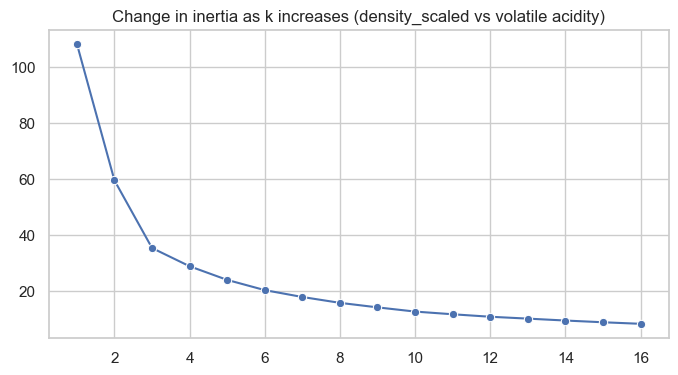

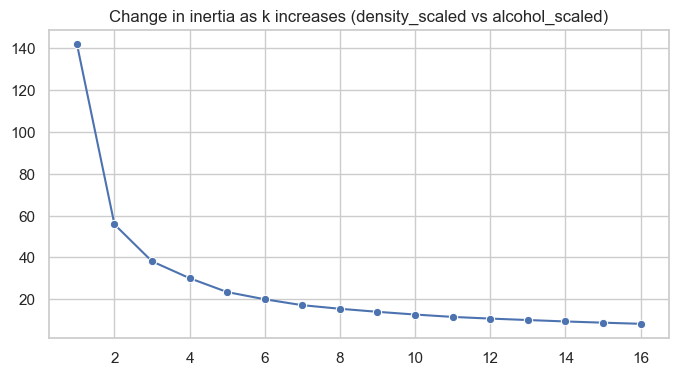

In [15]:
# plot the inartia for to chose the best k
plt.figure(figsize=(8, 4))
sns.lineplot(y = model_inertia, x=np.arange(1,len(model_cols)), marker="o")
plt.title("Change in inertia as k increases (density_scaled vs volatile acidity)")
plt.show

# plot the inartia for to chose the best k
plt.figure(figsize=(8, 4))
sns.lineplot(y = model_inertia2, x=np.arange(1,len(model_cols)), marker="o")
plt.title("Change in inertia as k increases (density_scaled vs alcohol_scaled)")
plt.show()

**Compare k's to above and bellow (centroids)**

**Cluster 3**

In [16]:
# creat a dataframe of the best model k
ceters = pd.DataFrame(model_centers[2], columns=list(feature_combinations[0]))

# creat a dataframe of the best model k
ceters2 = pd.DataFrame(model_centers2[1], columns=list(feature_combinations[2]))
ceters

,density_scaled,volatile_acidity_scaled
0,0.206723,0.147023
1,0.414565,0.172205
2,0.406773,0.445951


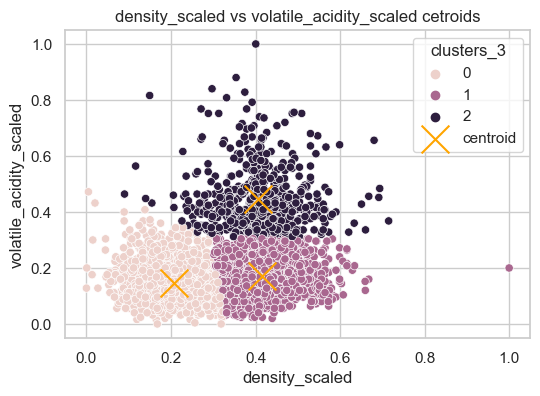

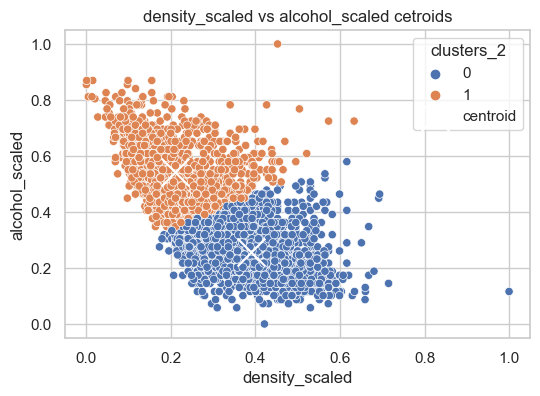

In [17]:
# vusialize the centroids
plt.figure(figsize=(6,4))
sns.scatterplot(data=train_scaled, x=feature_combinations[0][0], y=feature_combinations[0][1], hue=model_df.clusters_3)
ceters.plot.scatter(x=feature_combinations[0][0], y=feature_combinations[0][1], c='orange', marker='x', s=400, label='centroid', ax=plt.gca())
plt.title(f"{feature_combinations[0][0]} vs {feature_combinations[0][1]} cetroids")
plt.show()

# vusialize the centroids
plt.figure(figsize=(6,4))
sns.scatterplot(data=train_scaled, x=feature_combinations[2][0], y=feature_combinations[2][1], hue=model_df2.clusters_2)
ceters2.plot.scatter(x=feature_combinations[2][0], y=feature_combinations[2][1], c='white', marker='x', s=400, label='centroid', ax=plt.gca())
plt.title(f"{feature_combinations[2][0]} vs {feature_combinations[2][1]} cetroids")
plt.show()

**Cluster 4**

In [18]:
# creat a dataframe of the best model k
ceters = pd.DataFrame(model_centers[3], columns=list(feature_combinations[0]))

# creat a dataframe of the best model k
ceters2 = pd.DataFrame(model_centers2[2], columns=list(feature_combinations[2]))

ceters

,density_scaled,volatile_acidity_scaled
0,0.169649,0.155902
1,0.401166,0.451811
2,0.313874,0.140063
3,0.465631,0.195468


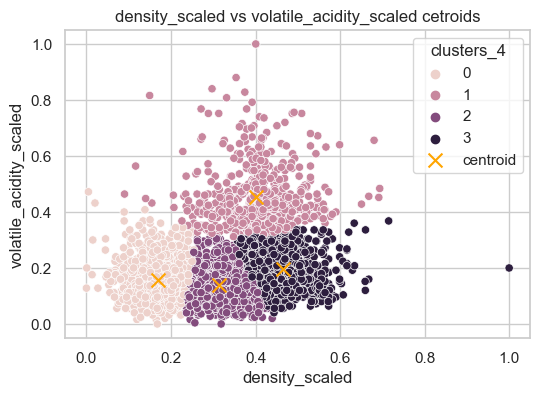

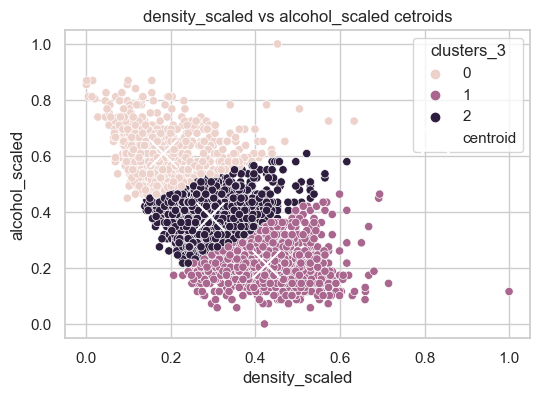

In [19]:
# vusialize the centroids
plt.figure(figsize=(6,4))
sns.scatterplot(data=train_scaled, x=feature_combinations[0][0], y=feature_combinations[0][1], hue=model_df.clusters_4)
ceters.plot.scatter(x=feature_combinations[0][0], y=feature_combinations[0][1], c='orange', marker='x', s=100, label='centroid', ax=plt.gca())
plt.title(f"{feature_combinations[0][0]} vs {feature_combinations[0][1]} cetroids")
plt.show

# vusialize the centroids
plt.figure(figsize=(6,4))
sns.scatterplot(data=train_scaled, x=feature_combinations[2][0], y=feature_combinations[2][1], hue=model_df2.clusters_3)
ceters2.plot.scatter(x=feature_combinations[2][0], y=feature_combinations[2][1], c='white', marker='x', s=400, label='centroid', ax=plt.gca())
plt.title(f"{feature_combinations[2][0]} vs {feature_combinations[2][1]} cetroids")
plt.show()


**Cluster 5**

In [20]:
# creat a dataframe of the best model k
ceters = pd.DataFrame(model_centers[4], columns=list(feature_combinations[0]))

# creat a dataframe of the best model k
ceters2 = pd.DataFrame(model_centers2[3], columns=list(feature_combinations[2]))

ceters

,density_scaled,volatile_acidity_scaled
0,0.472784,0.174140
1,0.419058,0.565857
2,0.169038,0.155453
3,0.393093,0.357089
4,0.312760,0.135058


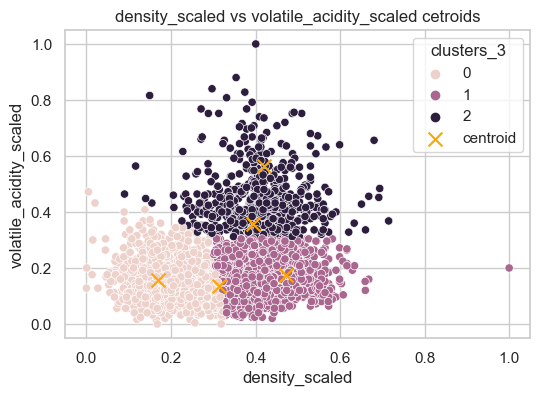

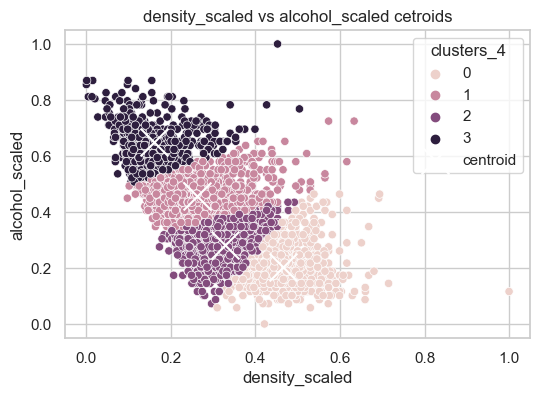

In [21]:
# vusialize the centroids
plt.figure(figsize=(6,4))
sns.scatterplot(data=train_scaled, x=feature_combinations[0][0], y=feature_combinations[0][1], hue=model_df.clusters_3)
ceters.plot.scatter(x=feature_combinations[0][0], y=feature_combinations[0][1], c='orange', marker='x', s=100, label='centroid', ax=plt.gca())
plt.title(f"{feature_combinations[0][0]} vs {feature_combinations[0][1]} cetroids")
plt.show()

# vusialize the centroids
plt.figure(figsize=(6,4))
sns.scatterplot(data=train_scaled, x=feature_combinations[2][0], y=feature_combinations[2][1], hue=model_df2.clusters_4)
ceters2.plot.scatter(x=feature_combinations[2][0], y=feature_combinations[2][1], c='white', marker='x', s=400, label='centroid', ax=plt.gca())
plt.title(f"{feature_combinations[2][0]} vs {feature_combinations[2][1]} cetroids")
plt.show()

3 LOOKS TO BE THE BEST K FOR DENSITY VS VOLATILE ACIDIC

AND

3 LOOKS TO BE THE BEST K FOR DENSITY VS ALCOHOL

**Predict the validation and test using beset model**

In [22]:
# ceate model object
kmean = KMeans(n_clusters= 3)
kmea_cls_2 = KMeans(n_clusters= 3)

# fit model object
kmean.fit(train_scaled[list(feature_combinations[0])])
kmea_cls_2.fit(train_scaled[list(feature_combinations[2])])

# make predictions
val_label = kmean.predict(val_scaled[list(feature_combinations[0])])
test_label = kmean.predict(test_scaled[list(feature_combinations[0])])

val_label2 = kmea_cls_2.predict(val_scaled[list(feature_combinations[2])])
test_label2 = kmea_cls_2.predict(test_scaled[list(feature_combinations[2])])

**Add best cluster mode to the data frame**

In [23]:
# Train
train_scaled["dens_valAcid_cluster"] = model_df.clusters_3
val_scaled["dens_valAcid_cluster"] = val_label
test_scaled["dens_valAcid_cluster"] = test_label

train_scaled["dens_alc_cluster"] = model_df2.clusters_3
val_scaled["dens_alc_cluster"] = val_label2
test_scaled["dens_alc_cluster"] = test_label2

train_scaled.head(1)

,fixed_acidity_scaled,volatile_acidity_scaled,citric_acid_scaled,residual_sugar_scaled,chlorides_scaled,free_sulfur_dioxide_scaled,total_sulfur_dioxide_scaled,density_scaled,ph_scaled,sulphates_scaled,alcohol_scaled,quality,wine_clr,red,white,clusters_3,clusters_2,dens_valAcid_cluster,dens_alc_cluster
0,0.173554,0.144,0.195122,0.058065,0.074725,0.17301,0.349515,0.225528,0.705426,0.289773,0.478261,5,white,0,1,0,1,0,2


**Save new data**

In [24]:
# save train, validate and test
train_scaled.to_csv("../00_project_data/1-1_training_data.csv", mode ="w")
val_scaled.to_csv("../00_project_data/1-2_validation_data.csv", mode ="w")
test_scaled.to_csv("../00_project_data/1-3_testing_data.csv", mode ="w")
print("Three datasets saved")

Three datasets saved


**Take aways**

- Top three selected features:
    - `density_scaled, volatile_acidity_scaled, white`
- Found 3 cluster with the following combination:
    - `density_scaled, volatile_acidity_scaled`
        - 0:
            - high density and low volatile acidity
        - 1:
            - low density and low volatile acidity
        - 2:
            - high density and high volatile acidity
- Found 3 cluster with the following combination:
    - `density_scaled, alcohol_scaled`
        - 0:
            - high density and high alcohol
        - 1:
            - high density and low alcohol
        - 2:
            - mid density and min alcohol